In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.constants as const
from IPython.core.pylabtools import figsize
from matplotlib.lines import lineStyles
from scipy.interpolate import interp1d

# 常量定义
G = const.G # 万有引力常数, m^3 kg^-1 s^-2
c = const.c  # 光速, m/s
msun = 1.989e30  # 太阳质量, kg
pc = 3.086e16  # pc到m的转换

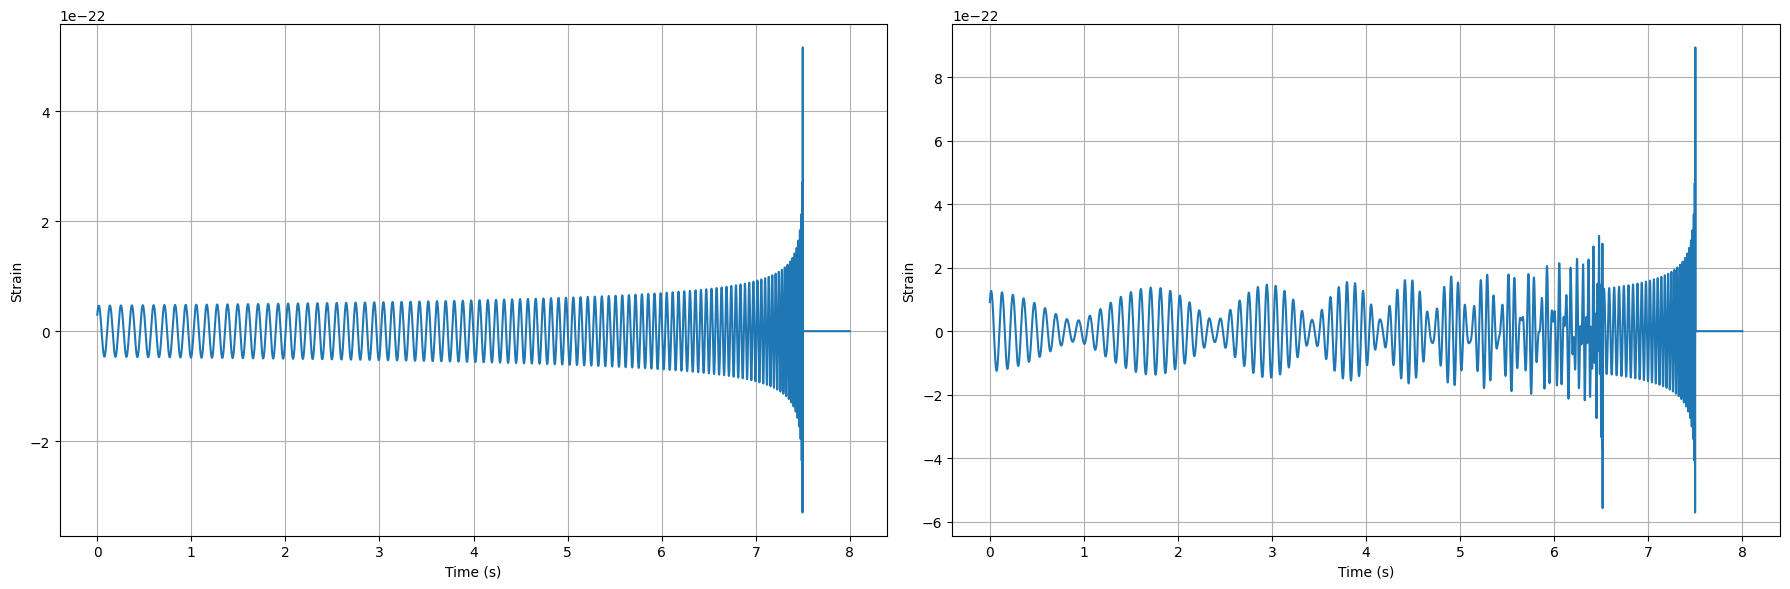

In [3]:
# 初始参数 - GW150914
m1 = 40  # 第一个黑洞质量（太阳质量）
m2 = 30  # 第二个黑洞质量（太阳质量）
# M_chirp = (m1 * m2 / (m1 + m2) ** 2) ** (3/5) * (m1 + m2)  # 啁啾质量
M_chirp = (m1 * m2) ** (3 / 5) / (m1 + m2) ** (1 / 5)
M_chirp = M_chirp * msun  # 转换为kg

# 透镜参数
mlz = 5e4 * msun  # 透镜质量
y = 0.5  # 影响参数

# 采样参数 - 与LIGO一致
fs = 4096  # 采样率调整为LIGO的标准采样率
dt = 1 / fs
t = np.arange(0, 8, dt)  # 时间范围调整，使其更加聚焦于合并前的最后阶段
t_len = t[-1] - t[0]
N = len(t)

# 引力波参数 - 调整以匹配GW150914
tc = 7.5  # 合并时间，选择使信号在最后时刻达到峰值
phi_c = 0.25 * np.pi

# SIS透镜参数
r = 3100 * 1e6 * pc  # 源距离 

# 函数：引力波波形生成（啁啾信号）
def generate_gw_signal(t):
    # 确保在合并前截止
    valid_idx = t < tc
    t_valid = t[valid_idx]
    # 计算Θ(t)，控制信号的频率演化
    Theta = c ** 3 * (tc - t_valid) / (5 * G * M_chirp)
    # 计算振幅部分
    A = (G * M_chirp / (c ** 2 * r)) * Theta ** (-1 / 4)

    # 原始相位计算
    phase = 2 * phi_c - 2 * Theta ** (5 / 8)

    # 计算波形
    h = np.zeros_like(t)
    h[valid_idx] = A * np.cos(phase)
    return h


## 函数：透镜放大因子（时域方法2）
def lens_time(h_original, t, y):
    # 计算放大因子
    mu_plus = np.sqrt(1 + 1 / y)  # 主像
    mu_minus = np.sqrt(-1 + 1 / y) if y < 1 else 0  # 次像

    # 计算物理时间延迟
    td = 8 * y * mlz * G /(c ** 3) # 秒
    # 创建插值函数
    interp_func = interp1d(t, h_original, kind='cubic', bounds_error=False, fill_value=0)
    # 创建延迟时间点
    t_delayed = t + td

    # 计算延迟信号
    h_delayed = interp_func(t_delayed)

    # 透镜化效应：原始信号和延迟信号的组合
    h_lensed = mu_plus * h_original

    # 只有在y<1时才有次像
    if y < 1:
        h_lensed = h_lensed - mu_minus * h_delayed  # 次像有π相位差(负号)
    return h_lensed


# 计算引力波信号
h = generate_gw_signal(t)
# h = h * 0.25
h_lens = lens_time(h, t, y)
# 绘制原始信号的时域
plt.figure(figsize=(18, 6))
# 时域原始信号
plt.subplot(121)
plt.plot(t, h)
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.subplot(122)
plt.plot(t, h_lens, label='Lens Signal(T)')
plt.xlabel('Time (s)')
plt.ylabel('Strain')
plt.grid(True)
plt.tight_layout()
# plt.subplot(133)
# plt.plot(t, h_lens, 'orange', label='Lens Signal')
# plt.plot(t, h, 'b', label='Signal')
# plt.xlabel('Time (s)')
# plt.ylabel('Strain')
# plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

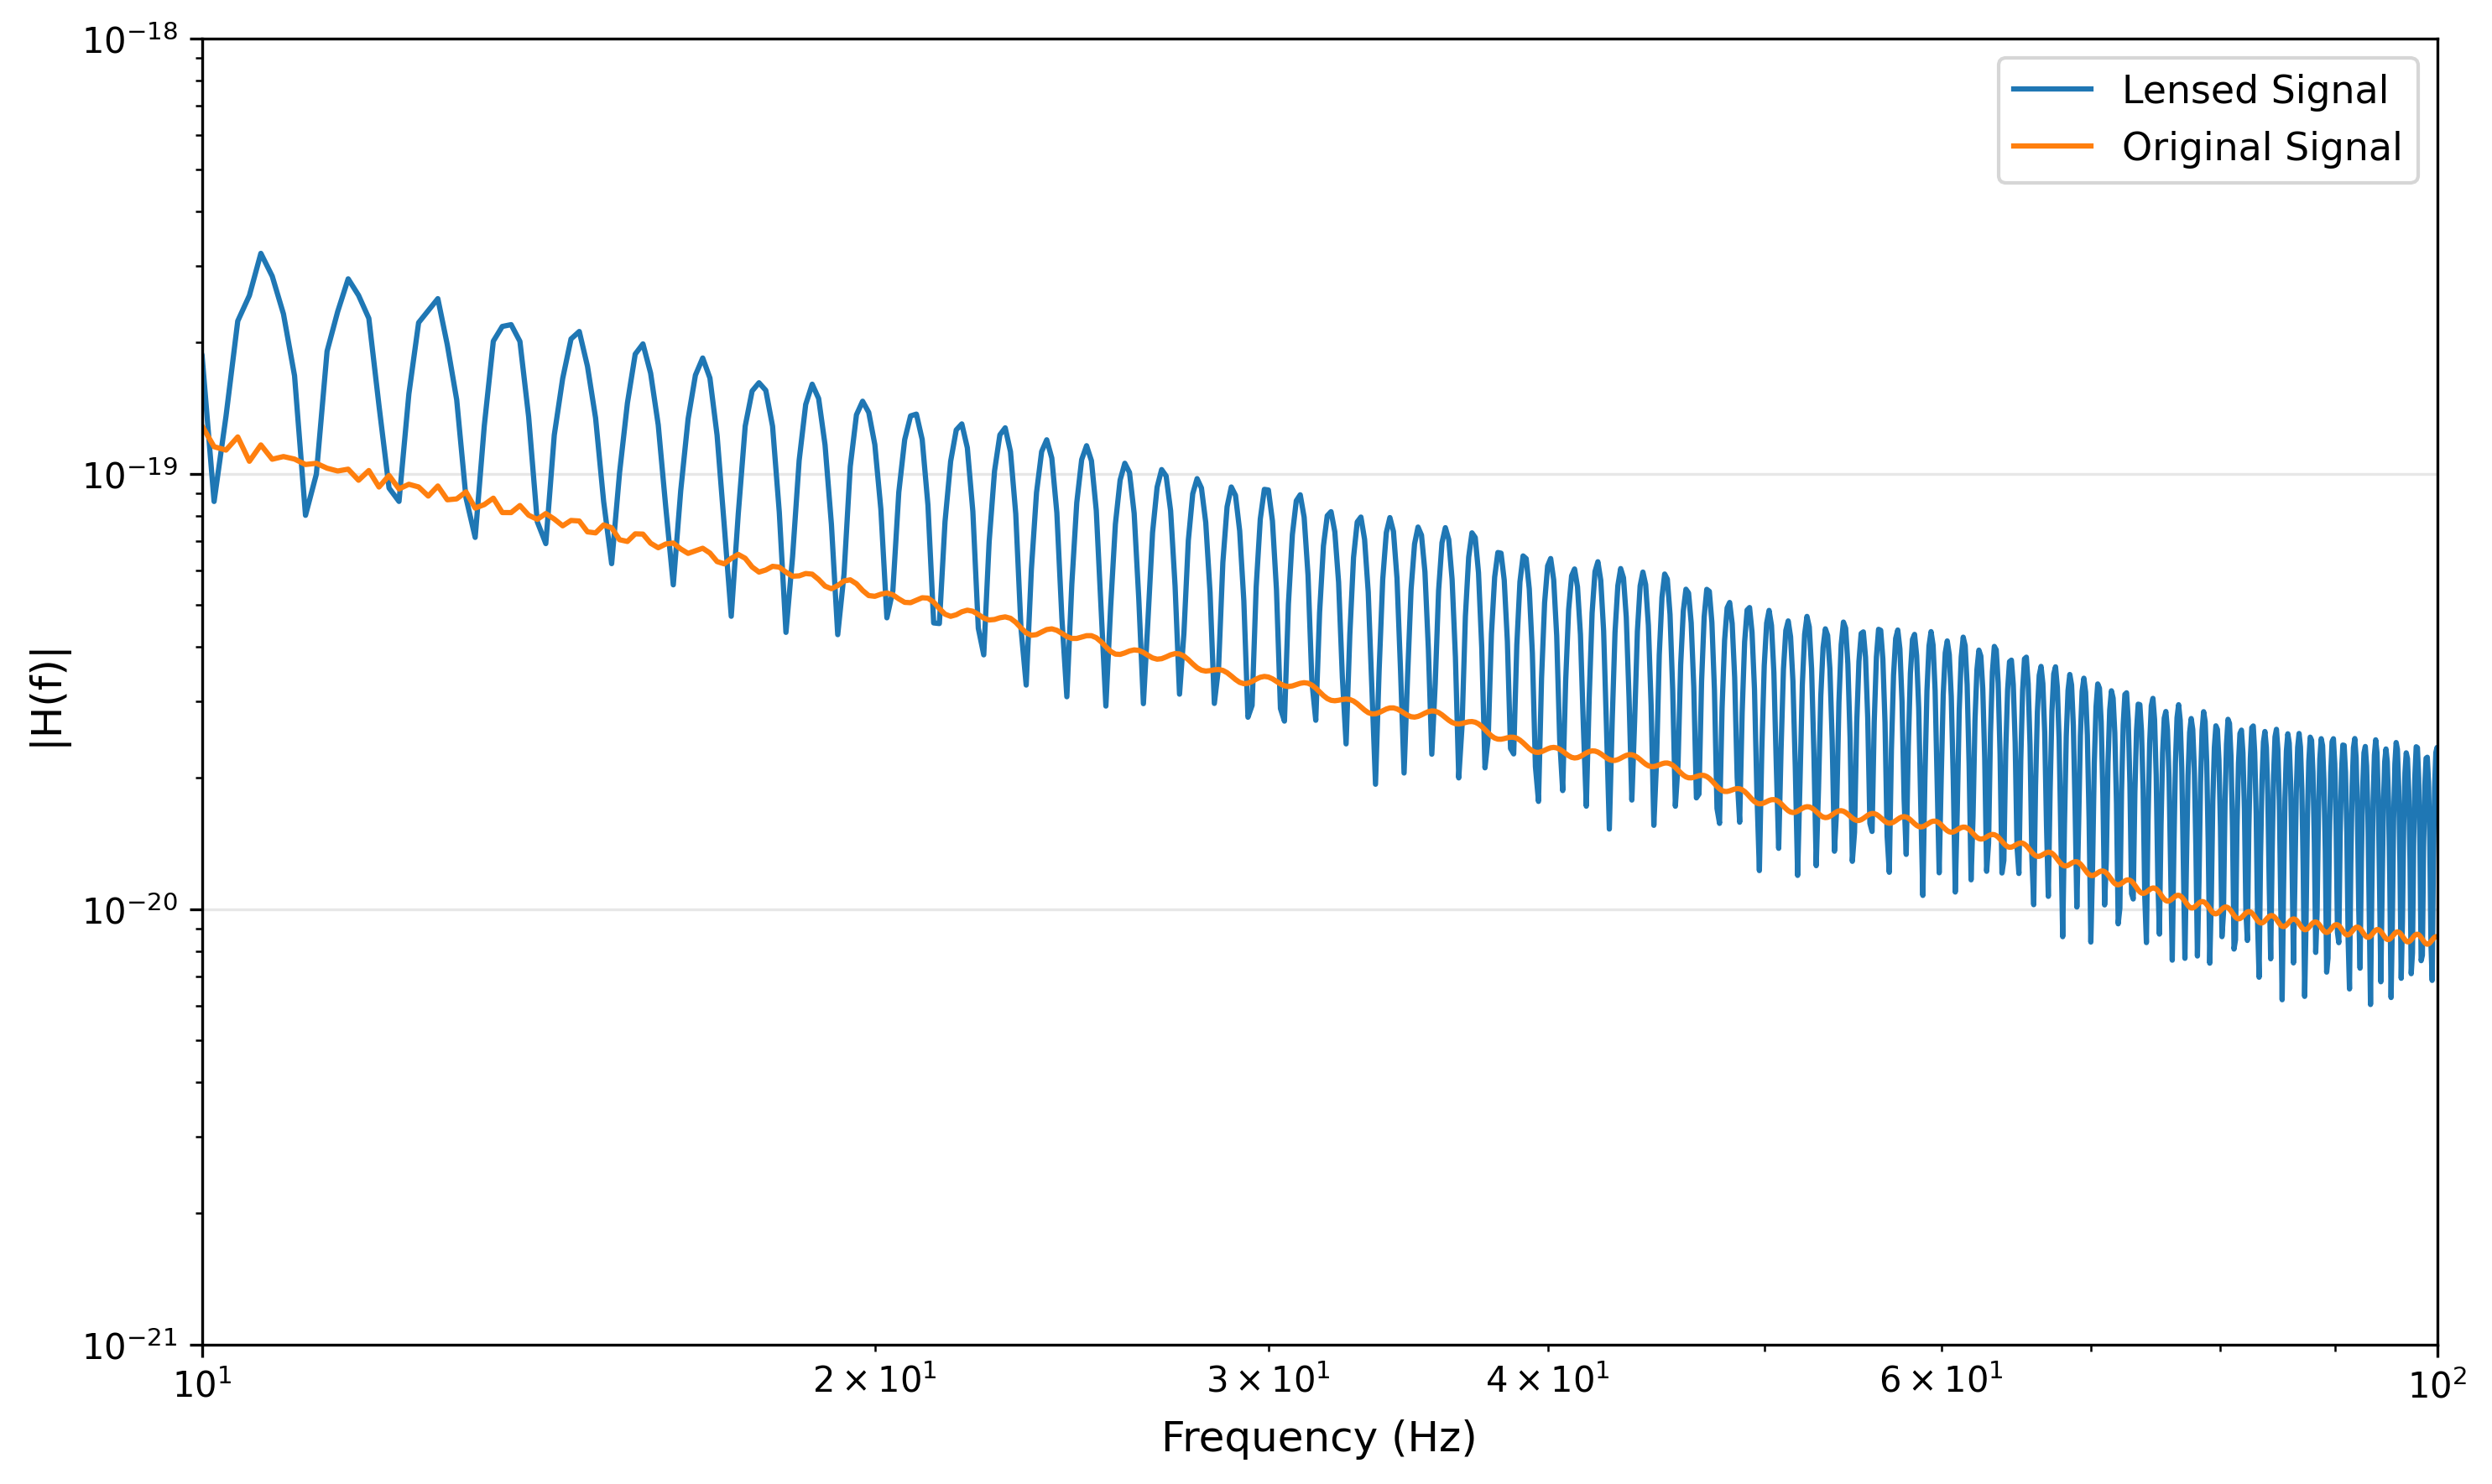

In [18]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import numpy as np

# 对原始信号进行傅里叶变换
H = fft(h)
# 计算频率轴
freq = fftfreq(N, dt)

# 对透镜信号进行傅里叶变换
H_lens = fft(h_lens)

# 只取正频率部分
positive_freq_idx = freq >= 0
freq_positive = freq[positive_freq_idx]
H_positive = H[positive_freq_idx]
H_lens_positive = H_lens[positive_freq_idx]

# 绘制两个信号的频域图对比
plt.figure(figsize=(10, 6), dpi=300)  # 设置合适的图片尺寸
plt.plot(freq_positive, np.abs(H_lens_positive), label='Lensed Signal', linewidth=1.5)
plt.plot(freq_positive, np.abs(H_positive), label='Original Signal', linewidth=1.5)
plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('|H(f)|', fontsize=12)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 100)
plt.ylim(1e-21,1e-18)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存为高质量PDF
plt.savefig('images/Frequency.pdf', 
            format='pdf',           # 明确指定PDF格式
            bbox_inches='tight',    # 自动调整边界
            dpi=200,               # 高分辨率
            facecolor='white',     # 背景色
            edgecolor='none')      # 无边框

plt.show()

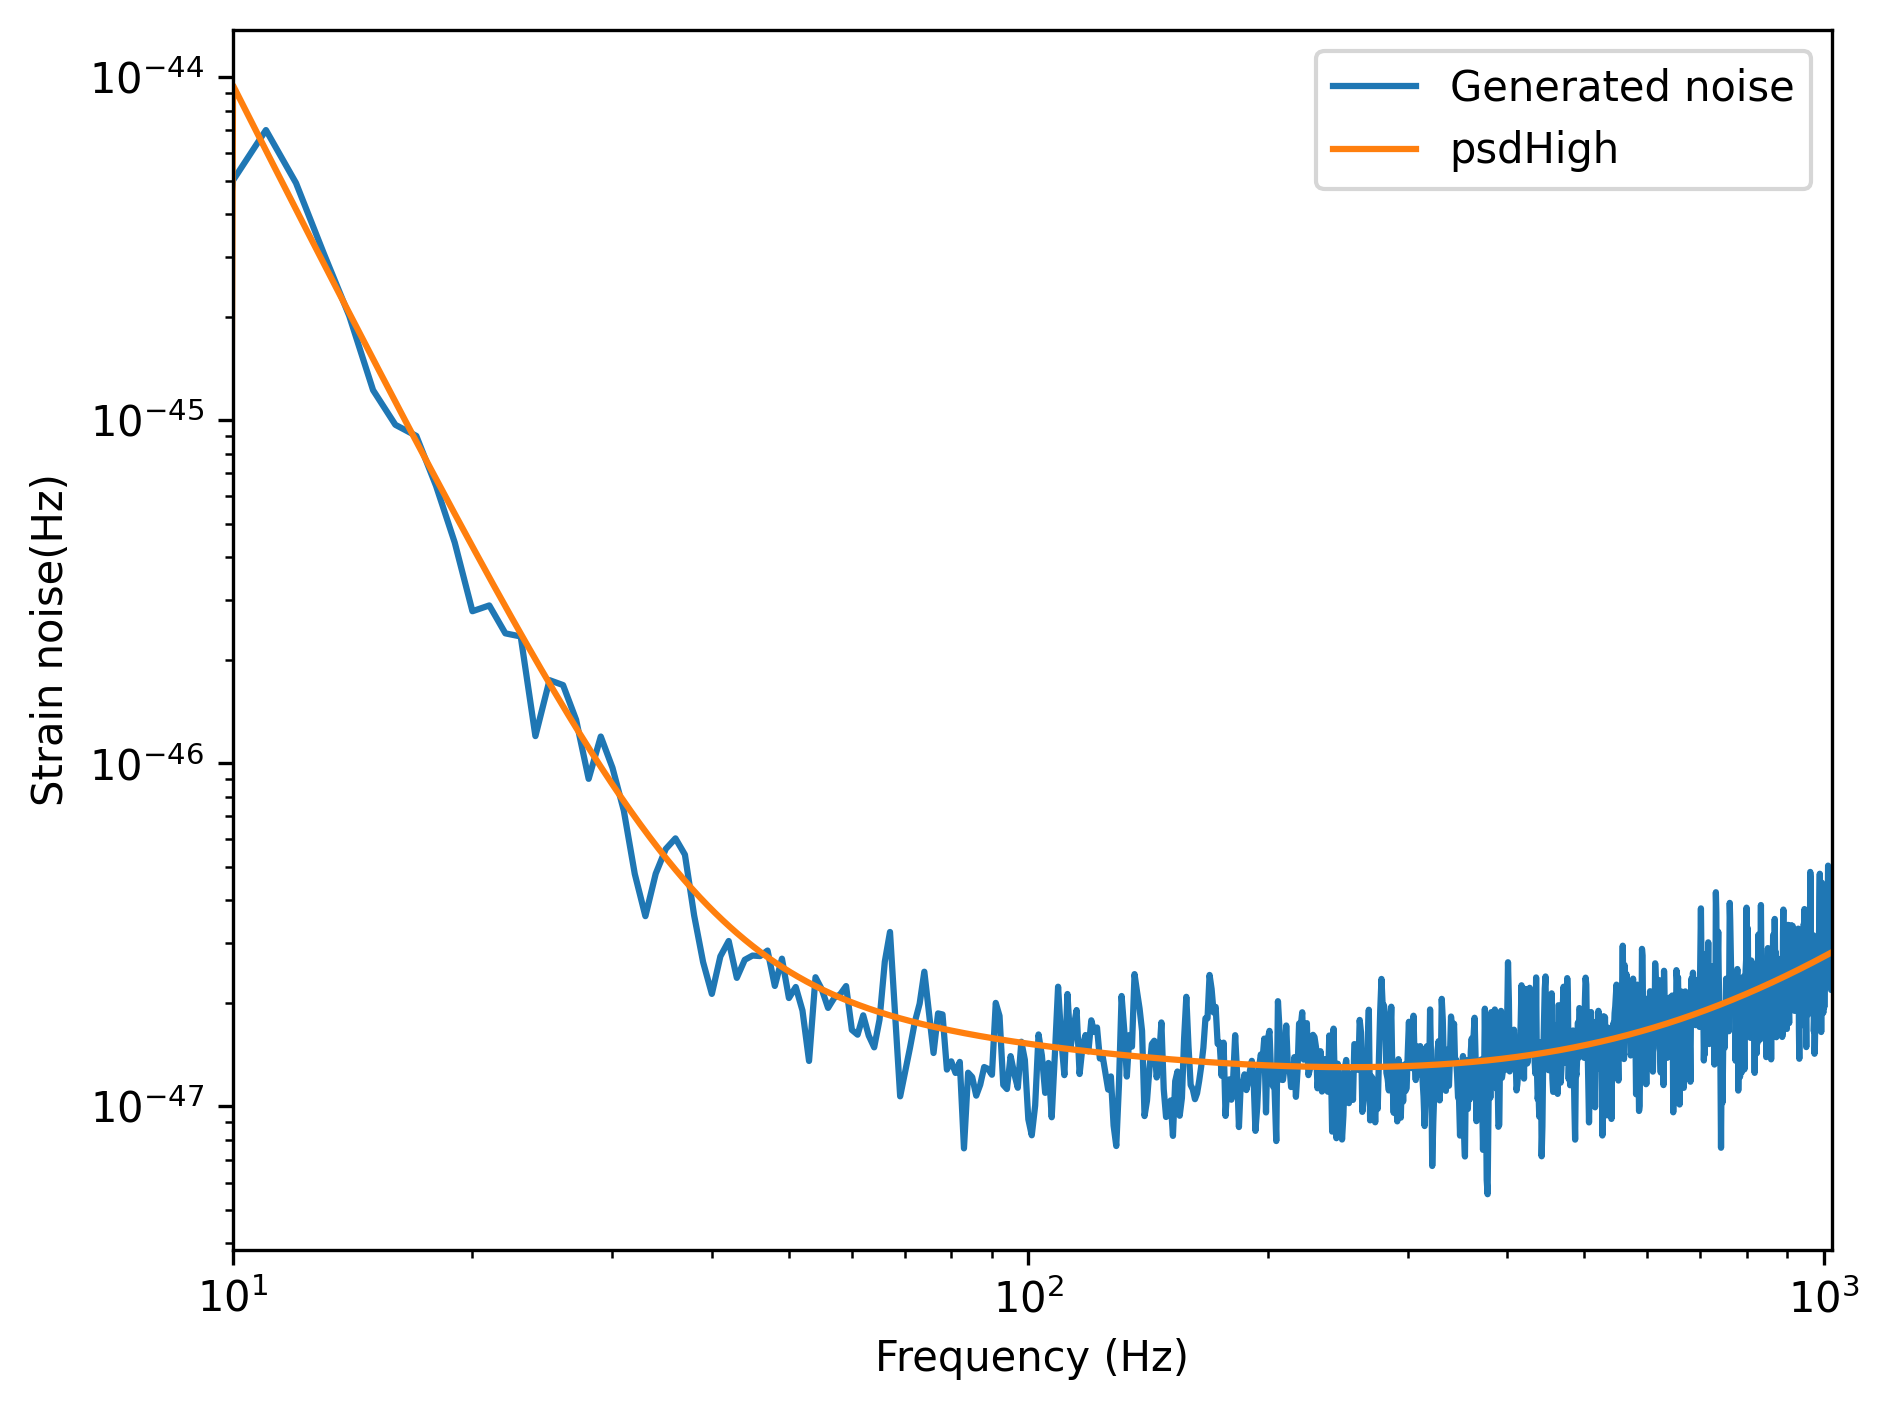

In [19]:
from scipy.io import savemat
import pycbc.noise
import pycbc.psd
from scipy.signal import welch

fs = 4096  # This seems to be missing in your code
N = 8 * fs  # Total number of samples for 20 seconds
flow = 10
delta_f = 1 / 8
delta_t = 1 / fs
t = np.arange(0, N) * delta_t

# Generate PSD and noise
f_len = int(N // 2) + 1
psdHigh = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, flow)
psdHigh = np.maximum(psdHigh, 1e-47)
output_noise = pycbc.noise.noise_from_psd(N, delta_t, psdHigh)

# # Plot time domain
fig = plt.figure(dpi = 300)
# plt.subplot(121)
# plt.plot(t, output_noise)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')

# Calculate PSD with Welch method - use proper parameters
f, pxx = welch(output_noise, fs=fs, nperseg=4096, noverlap=2048, scaling='density')

# Convert PyCBC PSD to numpy array with correct frequency axis
psd_freq = np.arange(len(psdHigh)) * delta_f

# Plot frequency domain
# plt.subplot(122)
plt.plot(f, pxx, label='Generated noise')
plt.plot(psd_freq, psdHigh, label='psdHigh')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain noise(Hz)')
plt.xlim(10,1024)
plt.tight_layout()
# 保存为高质量PDF
plt.savefig('images/PSD.pdf', 
            format='pdf',           # 明确指定PDF格式
            bbox_inches='tight',    # 自动调整边界
            dpi=200,               # 高分辨率
            facecolor='white',     # 背景色
            edgecolor='none')      # 无边框
plt.show()

savemat('noise.mat', {'noise': output_noise, 'psd': psdHigh})

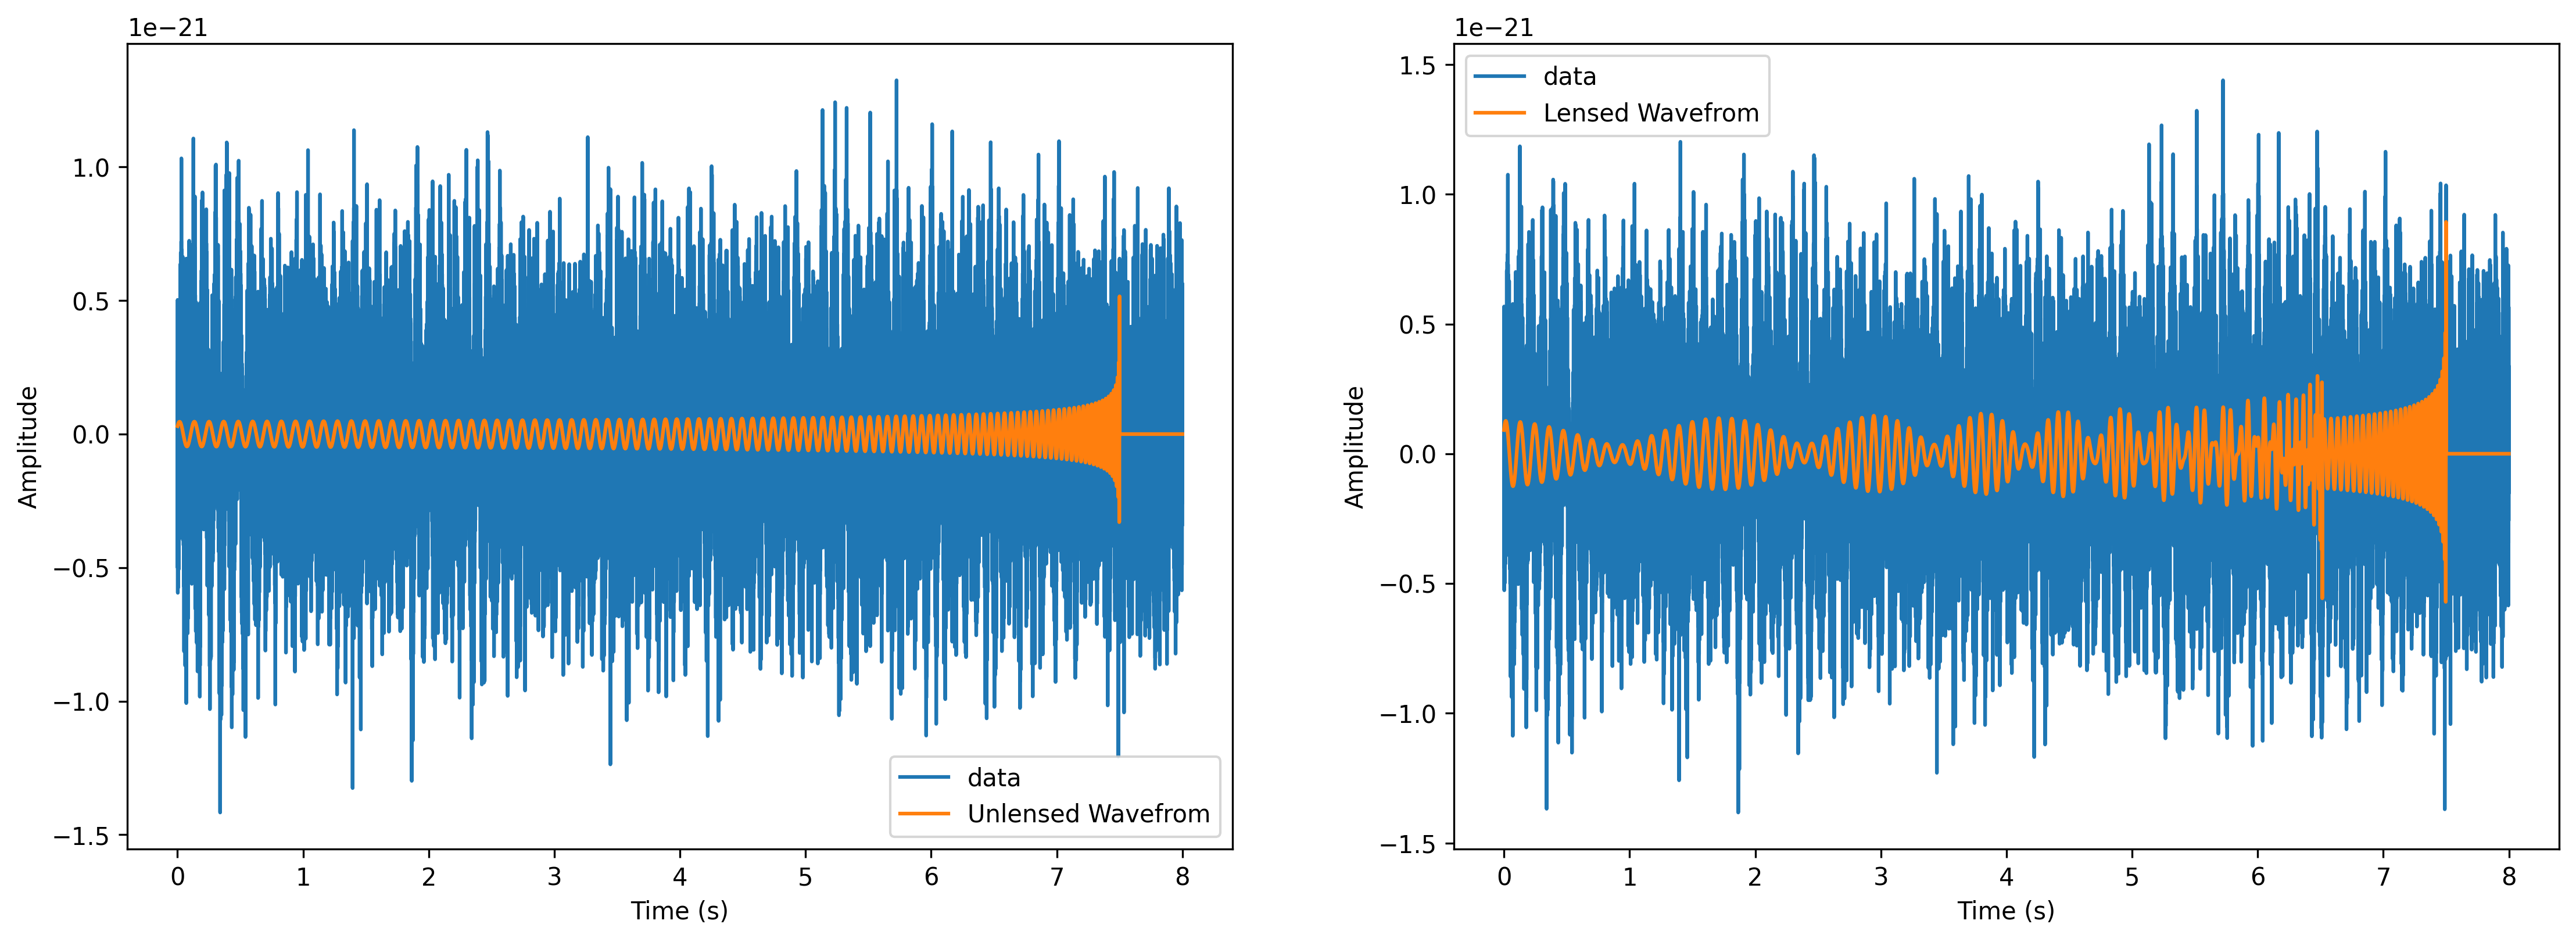

In [23]:
data = h + output_noise
data_lens = h_lens + output_noise
# data = h_windowed + output_noise
# data_lens = h_lens_windowed + output_noise

fig = plt.figure(figsize=(18,6),dpi=300)
plt.subplot(121)
plt.plot(t, data, label='data')
# plt.plot(t, h_windowed, label='Signal')
plt.plot(t, h, label='Unlensed Wavefrom')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(122)
plt.plot(t, data_lens, label='data')
# plt.plot(t, h_lens_windowed, label='lens signal')
plt.plot(t, h_lens, label='Lensed Wavefrom')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.savefig('images/signal_data.pdf', 
            format='pdf',           # 明确指定PDF格式
            bbox_inches='tight',    # 自动调整边界
            dpi=200,               # 高分辨率
            facecolor='white',     # 背景色
            edgecolor='none')      # 无边框
plt.show()

savemat('data_without_lens.mat', {'data': data, 'samples': fs})
savemat('data.mat', {'data': data_lens, 'samples': fs})

In [7]:
import pycbc.filter
from pycbc.types import TimeSeries, FrequencySeries
import pandas as pd

# 确保所有变量都是numpy数组
h_np = np.array(h, dtype=float)
h_lens_np = np.array(h_lens, dtype=float)
if hasattr(psdHigh, 'numpy'):
    psdHigh_np = psdHigh.numpy()
else:
    psdHigh_np = np.array(psdHigh, dtype=float)


# PyCBC方法计算信噪比
def calculate_snr_pycbc(signal, psd, fs):
    """
    使用PyCBC的matched_filter计算信噪比
    """
    # 创建PyCBC的TimeSeries对象
    delta_t = 1.0 / fs
    ts_signal = TimeSeries(signal, delta_t=delta_t)

    # 创建PyCBC的FrequencySeries对象
    delta_f = 1.0 / (len(signal) * delta_t)
    # 确保PSD长度与频率点数匹配

    psd_series = FrequencySeries(psd, delta_f=delta_f)

    # 使用matched_filter计算SNR
    # 模板与信号匹配（两者相同）
    snr = pycbc.filter.matched_filter(ts_signal, ts_signal, psd=psd_series, low_frequency_cutoff=10.0)
    # 获取最大SNR值
    max_snr = abs(snr).max()
    return float(max_snr)

# 计算SNR
print("\n===== 使用PyCBC方法计算信噪比 =====")
try:
    snr_pycbc_h = calculate_snr_pycbc(h_np, psdHigh_np, fs)
    snr_pycbc_h_lens = calculate_snr_pycbc(h_lens_np, psdHigh_np, fs)
    if snr_pycbc_h is not None and snr_pycbc_h_lens is not None:
        print(f"未透镜化信号信噪比 (PyCBC): {snr_pycbc_h:.4f}")
        print(f"透镜化信号信噪比 (PyCBC): {snr_pycbc_h_lens:.4f}")
        print(f"透镜效应导致的信噪比增强: {snr_pycbc_h_lens / snr_pycbc_h:.4f}倍")
    else:
        print("PyCBC方法计算失败")
except Exception as e:
    print(f"PyCBC方法出错: {e}")
    snr_pycbc_h = None
    snr_pycbc_h_lens = None


===== 使用PyCBC方法计算信噪比 =====
未透镜化信号信噪比 (PyCBC): 16.6807
透镜化信号信噪比 (PyCBC): 33.3713
透镜效应导致的信噪比增强: 2.0006倍


In [8]:
I = np.abs(-1 + 1/y) / np.abs(1 + 1/y)
td = 8 * y * mlz * G /(c ** 3) # 秒
print(f'm1：{m1}')
print(f'm2：{m2}')
print(f'啁啾质量：{M_chirp / msun:.2f}')
print(f'合并时间：{tc:.4f}')
print(f'源距离：{r / 1e6 / pc :.4f}')
print(f'天体透镜质量：{mlz / msun:.4e}')
print(f"y:{y:.4f}")
print(f"通量比:{I:.4f}")
print(f"时间延迟:{td:.4f}")
print(f"相位：{phi_c:.4f}")

m1：40
m2：30
啁啾质量：30.09
合并时间：7.5000
源距离：3100.0000
天体透镜质量：5.0000e+04
y:0.5000
通量比:0.3333
时间延迟:0.9854
相位：0.7854


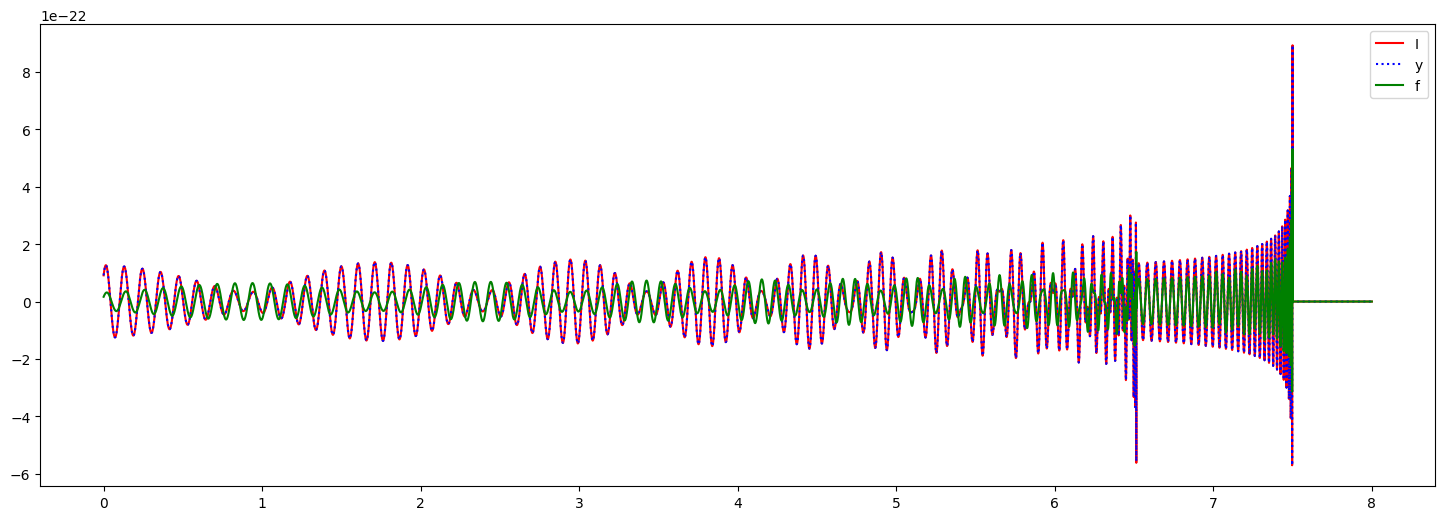

In [9]:
def lens(h, t,td, A):
    mu_plus = np.sqrt(2 / (1 - A))
    mu_minus = np.sqrt(2 * A / (1 - A))
    interp_func = interp1d(t, h, kind='cubic', bounds_error=False, fill_value=0.0)
    t_delayed = t + td
    h_delayed = interp_func(t_delayed)
    h_lensed = mu_plus * h
    if A > 0.01:
        h_lensed = h_lensed - mu_minus * h_delayed 
    
    return h_lensed

def apply_lensing_effect(h, t, A, delta_t, tc):
    """Apply lensing effect to a gravitational wave signal"""
    # Calculate FFT of signal
    n = len(h)
    h_fft = np.fft.fft(h)

    # Calculate frequency array
    dt = t[1] - t[0]
    freqs = np.fft.fftfreq(n, dt)

    # Calculate lens transfer function F(f) = 1 + A * exp(i * Phi)
    Phi = 2 * np.pi * freqs * delta_t
    lens_transfer = 1 + A * np.exp(1j * Phi)

    # Apply lensing effect in frequency domain
    h_lensed_fft = h_fft * lens_transfer

    # Convert back to time domain
    h_lens = np.real(np.fft.ifft(h_lensed_fft))

    # Ensure signal is zero after merger time
    h_lens[t > tc] = 0

    return h_lens
# 计算引力波信号
h = generate_gw_signal(t)
# h = h * 0.25
h_lens1 = lens(h, t,td = 0.9854,A = 0.3333)
h_lens2 = apply_lensing_effect(h,t,A = 0.333,delta_t = 0.9854,tc=7.5)
# 绘制原始信号的时域

fig = plt.figure(figsize=(18, 6))
plt.plot(t, h_lens1,'red',label = 'I')
plt.plot(t,h_lens,'blue',linestyle=':',label = 'y')
plt.plot(t, h_lens2,'green',label = 'f')
plt.legend()
plt.show()

I = 0.00755667506297226
td = 1.9412193863326432


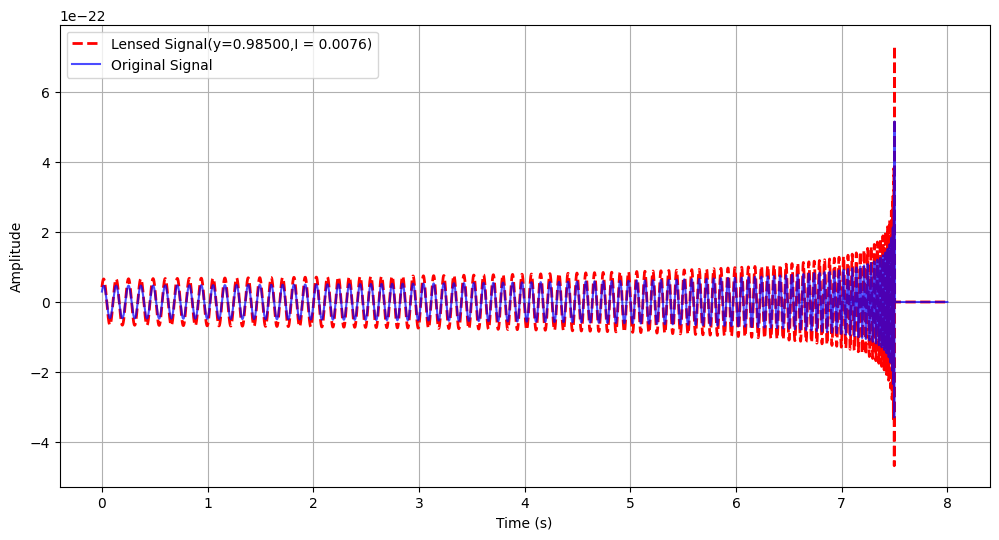

In [10]:
# 输入参数 y=0.99
y = 0.985
A = np.abs(-1 + 1/y) / np.abs(1 + 1/y)  # 计算 I
td = 8 * y * mlz * G / (c ** 3)         # 计算时间延迟 (s)
print("I =", A)
print("td =", td)
# 计算透镜效应后的信号
h_lensed = lens(h, t, td, A)

# 绘制对比图
plt.figure(figsize=(12, 6))
plt.plot(t, h_lensed, 'r--', label=f'Lensed Signal(y={y:.5f},I = {A:.4f})', linewidth=2)
plt.plot(t, h, 'b-', label=f'Original Signal', alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()